In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np
import string
from tqdm import tqdm

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from torchsummary import summary

import torch, gc
gc.collect()
torch.cuda.empty_cache()
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import models, utils

import matplotlib.pyplot as plt # plotting
from PIL import Image
import matplotlib.patches as patches
import matplotlib.image as IMG
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.io

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
#https://www.kaggle.com/datamunge/sign-language-mnist
train_df = pd.read_csv("D:/GeekBrains/pytorch/les06/data/gesture_dataset/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("D:/GeekBrains/pytorch/les06/data/gesture_dataset/sign_mnist_test/sign_mnist_test.csv")

In [3]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
alpha_dict = {idx:letter for idx, letter in enumerate(string.ascii_lowercase)}
alpha_dict

{0: 'a',
 1: 'b',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'j',
 10: 'k',
 11: 'l',
 12: 'm',
 13: 'n',
 14: 'o',
 15: 'p',
 16: 'q',
 17: 'r',
 18: 's',
 19: 't',
 20: 'u',
 21: 'v',
 22: 'w',
 23: 'x',
 24: 'y',
 25: 'z'}

In [5]:
class SignDataset(Dataset) :
    def __init__(self, img, label) :
        self.classes = np.array(label)
        img = img / 255.0
        self.img = np.array(img).reshape(-1, 28, 28, 1)
        
        self.transform = T.Compose([
            T.ToTensor()
        ])
        
    def __len__(self) :
        return len(self.img)
    
    def __getitem__(self, index) :
        label = self.classes[index]
        img = self.img[index]
        img = self.transform(img)
        
        label = torch.LongTensor([label])
        img = img.float()
        
        return img, label

In [6]:
train_set = SignDataset(train_df.drop('label', axis=1), train_df['label'])
test_set = SignDataset(test_df.drop('label', axis=1), test_df['label'])

In [7]:
def show_image(img, label, dataset):
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Label: {dataset.classes[label]}\nAlpha Label: {alpha_dict[dataset.classes[label]]}")

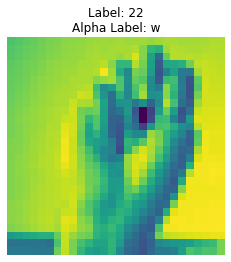

In [8]:
show_image(*train_set[4], train_set)

In [9]:
batch_size = 128
train_dl = DataLoader(train_set, batch_size=batch_size)
test_dl = DataLoader(test_set, batch_size=batch_size)

In [10]:
def conv_block(in_channels, out_channels, pool=False, drop=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    if drop: layers.append(nn.Dropout())
    return nn.Sequential(*layers)

In [11]:
class SignConvNet(nn.Module):
    def __init__(self, in_channels, out_classes):
        super().__init__()
        self.conv1 = conv_block(in_channels, 16)
        self.conv2 = conv_block(16, 32, pool=True)
        self.conv3 = conv_block(32, 64, pool=True, drop=True)
        self.fc =  nn.Sequential(*[
                        nn.Flatten(),
                        nn.Linear(7 * 7 * 64, out_classes)
                    ])
        
    def forward(self, img):
        img = self.conv1(img)
        img = self.conv2(img)
        img = self.conv3(img)
        return self.fc(img)

In [12]:
num_classes = len(alpha_dict)
model = SignConvNet(1, num_classes).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           4,640
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
         MaxPool2d-7           [-1, 32, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          18,496
       BatchNorm2d-9           [-1, 64, 14, 14]             128
             ReLU-10           [-1, 64, 14, 14]               0
        MaxPool2d-11             [-1, 64, 7, 7]               0
          Dropout-12             [-1, 64, 7, 7]               0
          Flatten-13                 [-1, 3136]               0
           Linear-14                   

In [13]:
# epochs = 10
# losses = []
# for epoch in range(epochs):
#     # for custom progress bar
#     with tqdm(train_dl, unit="batch") as tepoch:
#         epoch_loss = 0
#         epoch_acc = 0
#         for data, target in tepoch:
#             tepoch.set_description(f"Epoch {epoch + 1}")
#             data, target = data.to(device), target.to(device) # move input to GPU
#             out = model(data)
#             loss = criterion(out, target.squeeze())
#             epoch_loss += loss.item()
#             loss.backward()
#             optim.step()
#             optim.zero_grad()
#             tepoch.set_postfix(loss = loss.item()) # show loss and per batch of data
#     losses.append(epoch_loss)

In [14]:
# torch.save(model.state_dict(), 'sign_conv.pth')

### test

In [15]:
model.load_state_dict(torch.load('./sign_conv.pth'))

<All keys matched successfully>

100%|███████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 86.59batch/s]


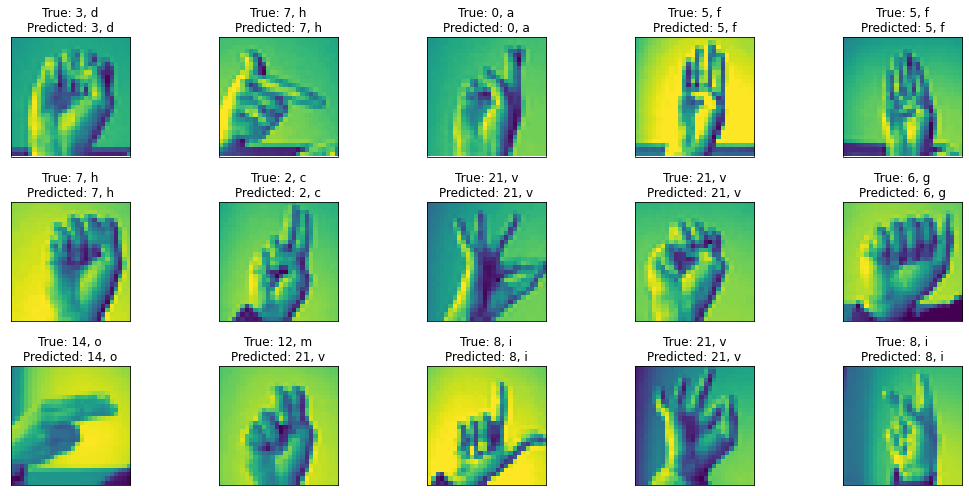

In [16]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    with tqdm(test_dl, unit="batch") as tepoch:
        for inp, labels in tepoch:
            inp, labels = inp.to(device), labels.to(device)
            y_test_pred = model(inp)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(labels.cpu().numpy())

inds = np.random.randint(len(test_set), size=15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

flat_pred = []
flat_true = []
for i in range(len(y_pred_list)):
    for j in range(len(y_pred_list[i])):
        flat_pred.append(y_pred_list[i][j])
        flat_true.append(y_true_list[i][j])

for i, ax in zip(inds, axes.flat):
    img, label = test_set[i]
    ax.imshow(img.permute(1, 2, 0))
    dict_real = alpha_dict[test_set.classes[label]]
    dict_pred = alpha_dict[test_set.classes[flat_pred[i]]]
    ax.set_title(f"True: {test_set.classes[label]}, {dict_real}\nPredicted: {test_set.classes[flat_pred[i]]}, {dict_pred}")
plt.tight_layout()
plt.show()

#### real screenshot test

In [17]:
%store -r cropped_hand

In [18]:
img28 = cv2.resize(cropped_hand,(28,28))
img28 = cv2.cvtColor(img28, cv2.COLOR_BGR2RGB)
# Превращаем в 1-канальное серое изображение
img28 = cv2.cvtColor(img28, cv2.COLOR_BGR2GRAY)
img28 = Image.fromarray(img28)
#face = face.resize((48,48))
img28 = np.asarray(img28).astype('float')
img28 = torch.as_tensor(img28)

img28.shape


torch.Size([28, 28])

In [19]:
test_img = img28.unsqueeze(0)
test_img = test_img.type(torch.FloatTensor)
test_img.dtype

torch.float32

In [20]:
model.eval()
output = model(test_img[None, ...].to(device))

In [21]:
output

tensor([[ -6.4213, -14.7737,  -5.9941,  -4.8512,  -8.5989,  -3.4522,  -0.6594,
           1.8878,  -3.2984, -18.6053, -14.3820,   8.0293,  -7.8949,  -7.5217,
         -10.2858,   2.2787,  -2.5127,  -6.5732,  -4.9528,  -4.9724, -14.6496,
         -13.0840, -14.9903,   2.4541,   0.0648, -16.4048]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [22]:
_, test_pred = torch.max(output, dim = 1)
test_pred.cpu().numpy()

array([11], dtype=int64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Predicted label: l')

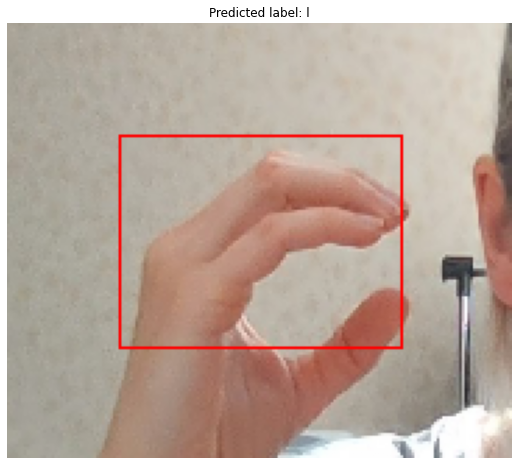

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
   
ax.set_axis_off()
ax.imshow(cropped_hand)
ax.set_title(f'Predicted label: {alpha_dict[test_pred.cpu().numpy()[0]]}')

In [24]:
#Не совсем удачно, но работает